In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import numpy as np
from json import loads
import json
from requests.exceptions import HTTPError
import pprint
from datetime import datetime
from dateutil.parser import parse
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from bayes_opt import BayesianOptimization
import toolz

shap.initjs()
from IPython.display import display, clear_output
from bayes_opt import BayesianOptimization
import time


In [69]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [70]:
print(np.__version__)
print(lgb.__version__)

1.16.4
2.1.2


In [71]:
target_diff = 0.003
stop_loss = 0.002
profit = 4.5
loss = 3

filename_date = '100519'


In [72]:
data = pd.read_csv(filename_date + '_mds_out_final_v7_USDCAD_v2.csv')
data.shape

(4797, 607)

In [73]:
data[['time', 'target_tp', 'target_sl', 'g', 'l', 'g_time', 'l_time', 'long_target', 'short_target']].head(20)

,time,target_tp,target_sl,g,l,g_time,l_time,long_target,short_target
0,2017-01-19 21:00:00,1.33478,1.32952,0.0,1.0,NaN,2017-01-19 22:00:00,0,1
1,2017-01-19 22:00:00,1.33099,1.32571,5.0,0.0,2017-01-20 02:00:00,NaN,1,0
2,2017-01-19 23:00:00,1.33193,1.32670,8.0,0.0,2017-01-20 05:00:00,NaN,1,0
3,2017-01-20 02:00:00,1.33284,1.32760,9.0,0.0,2017-01-20 06:00:00,NaN,1,0
4,2017-01-20 05:00:00,1.33464,1.32942,10.0,0.0,2017-01-20 07:00:00,NaN,1,0
5,2017-01-20 07:00:00,1.33793,1.33271,13.0,0.0,2017-01-20 10:00:00,NaN,1,0
6,2017-01-20 09:00:00,1.33917,1.33395,0.0,13.0,NaN,2017-01-20 10:00:00,0,1
7,2017-01-20 10:00:00,1.33740,1.33218,14.0,0.0,2017-01-20 11:00:00,NaN,1,0
8,2017-01-20 11:00:00,1.33973,1.33456,0.0,15.0,NaN,2017-01-20 12:00:00,0,1
9,2017-01-20 12:00:00,1.33510,1.32994,16.0,0.0,2017-01-20 13:00:00,NaN,1,0


In [74]:
shift_fields = ['bid_o', 'bid_h','bid_l','bid_c','ask_o','ask_h','ask_l','ask_c']

shift_counter = 1
shift_counter_max = 24*6

while shift_counter <= shift_counter_max:
    for s in shift_fields:
        col = s+'_past'+str(shift_counter)
        data[col] = ((data[s] - data[s].shift(shift_counter)) / data[s].shift(shift_counter))*100
        shift_counter+=1
print(data.shape)

(4797, 751)


In [75]:
data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek

In [76]:
data['day_of_week'].value_counts()

2    994
1    969
3    902
0    860
4    796
6    276
Name: day_of_week, dtype: int64

In [77]:
mds = data.copy()


model_cols = list(mds)
model_cols.remove('order')
model_cols.remove('time')
model_cols.remove('target_tp')
model_cols.remove('target_sl')
model_cols.remove('long_target')
model_cols.remove('short_target')
# model_cols.remove('g_diff')
# model_cols.remove('g_time_shift')
model_cols.remove('g_time')
model_cols.remove('l_time')
model_cols.remove('bucketwidth_x')
model_cols.remove('bucketwidth_y')
model_cols.remove('instrument')
model_cols.remove('instrument_x')
model_cols.remove('instrument_y')
model_cols.remove('match_time')
model_cols.remove('index')
model_cols.remove('g')
model_cols.remove('l')
model_cols.remove('ask_h')
model_cols.remove('ask_l')
model_cols.remove('ask_c')
model_cols.remove('ask_o')
model_cols.remove('bid_h')
model_cols.remove('bid_l')
model_cols.remove('bid_c')
model_cols.remove('bid_o')
model_cols.remove('volume')
model_cols.remove('diff')
model_cols.remove('same_time')



for m in model_cols:
#     print(m)
    mds[m] = pd.to_numeric(mds[m])
    

mds_train = mds[mds['time'] < '2019-06-01'].copy()
mds = mds[mds['time'] >= '2019-06-01'].copy()

X_train, X_test, y_train, y_test = train_test_split(
     mds_train[model_cols], mds_train['long_target'], test_size=0.33, random_state=42)
     
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

print(mds_train.shape)
print(mds.shape)

(4327, 753)
(470, 753)


In [78]:
def lgb_evaluate(num_leaves,
                 min_child_weight,
                 min_split_gain,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2,
                 min_data,
                 drop_rate,
                 skip_drop,
                 max_drop):

    params['num_leaves'] = int(num_leaves)
    params['min_child_weight'] = int(min_child_weight)
    params['feature_fraction'] = max(feature_fraction,0)
    params['min_split_gain'] = max(min_split_gain, 0)
    params['bagging_fraction'] = max(bagging_fraction,0)
    params['bagging_freq'] = int(bagging_freq)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['min_data'] = int(min_data)
    params['metric'] = 'binary_logloss'
    params['eta'] = 0.1
    params['boost_from_average'] = False
    params['is_unbalance'] = False
    params['num_threads'] = 2
    params['boosting_type']= 'dart'
    params['skip_drop'] = max(skip_drop,0)
    params['drop_rate'] = max(drop_rate,0)
    params['max_drop'] = int(max_drop)

    cv_result = lgb.cv(params, lgb_train, num_boost_round=num_rounds, nfold=3,
             seed=random_state, early_stopping_rounds=500, verbose_eval=50)

    return -cv_result['binary_logloss-mean'][-1]

In [79]:
# num_rounds = 3000
# random_state = 2016
# num_iter = 25
# init_points = 25
# params = {
#     'eta': 0.1,
# #     'silent': 1,
# #     'eval_metric': 'auc',
# #     'verbose_eval': True,
# #     'seed': random_state
# }

# lgbBO = BayesianOptimization(lgb_evaluate, {'num_leaves': (5, 100),
#                                             'min_child_weight': (0, 5),
#                                             'min_split_gain': (0, 5),
#                                             'feature_fraction': (0.1, 1),
#                                             'bagging_fraction': (0.1, 1),
#                                             'bagging_freq': (1, 10),
#                                             'lambda_l2': (0, 1),
#                                             'lambda_l1': (0, 1),
#                                             'min_data': (1,100),
#                                             'drop_rate': (0.1, 0.9),
#                                             'skip_drop': (0.1, 0.9),
#                                             'max_drop': (1,100)
#                                             })

# lgbBO.maximize(init_points=init_points, n_iter=num_iter)

In [80]:
# tracker = {'max':1, 'idx':1000}
# counter = 0
# for f in lgbBO.res:
#     if abs(f['target']) < tracker['max']:
#         tracker['max'] = abs(f['target'])
#         tracker['idx'] = counter
#     counter +=1
    
# best_params = lgbBO.res[tracker['idx']]['params']
# print(tracker)
# print()
# best_params

In [81]:
params = {
        'objective':'binary',
#         'boosting': 'dart',
#         'drop_rate': 0.3,
#         'max_drop': 50,
#         'skip_drop':0.2,
#         'uniform_drop': False,
        'boost_from_average': False,
        'learning_rate': 0.01,
        'min_data': 20,
        'num_leaves': 31,
#         'max_depth':6,
#         'lambda_l2': 0.1,
#         'lambda_l1': 0.1,
        'bagging_fraction': 0.6,
        'bagging_freq': 1,
        'min_child_weight': 1,
        'min_split_gain': 0.01,
        'verbose': 1,
        'feature_fraction': 0.2,
#         'scale_pos_weight': 100,
#         'is_unbalance': True,
        'metric': ['binary_logloss'],
        'max_bin': 63,
        'num_threads': 2
    } 

# params = {
#     'objective':'binary',
#     'boosting_type': 'dart',
#     'drop_rate': round(best_params['drop_rate'], 2),
#     'max_drop': int(best_params['max_drop']),
#     'skip_drop':  round(best_params['skip_drop'], 2),   
#     'boost_from_average': False,
#     'learning_rate':  0.05,
#     'max_depth': int(best_params['max_depth']),
#     'num_leaves': int(best_params['num_leaves']),
#     'lambda_l2': best_params['lambda_l2'],
#     'lambda_l1': best_params['lambda_l1'],
#     'bagging_fraction':  round(best_params['bagging_fraction'], 2),
#     'bagging_freq': int(best_params['bagging_freq']),
#     'min_data': int(best_params['min_data']),
#     'min_child_weight':  round(best_params['min_child_weight'], 2),
#     'min_split_gain':  round(best_params['min_split_gain'], 2),
#     'verbose': 1,
#     'feature_fraction': round(best_params['feature_fraction'], 2),
# #     'scale_pos_weight': lgbBO.res['max']['max_params']['scale_pos_weight'],
#     'metric': ['binary_error'],
#     'num_threads': 2,
# #     'is_unbalance': True,
# } 


In [82]:
num_round = 100000
lgb_model = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test], early_stopping_rounds=500, verbose_eval=50, keep_training_booster=True)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's binary_logloss: 0.661732
[100]	valid_0's binary_logloss: 0.647918
[150]	valid_0's binary_logloss: 0.63899
[200]	valid_0's binary_logloss: 0.633463
[250]	valid_0's binary_logloss: 0.629021
[300]	valid_0's binary_logloss: 0.625988
[350]	valid_0's binary_logloss: 0.625524
[400]	valid_0's binary_logloss: 0.62428
[450]	valid_0's binary_logloss: 0.622408
[500]	valid_0's binary_logloss: 0.621071
[550]	valid_0's binary_logloss: 0.620182
[600]	valid_0's binary_logloss: 0.618061
[650]	valid_0's binary_logloss: 0.618343
[700]	valid_0's binary_logloss: 0.617396
[750]	valid_0's binary_logloss: 0.617758
[800]	valid_0's binary_logloss: 0.617347
[850]	valid_0's binary_logloss: 0.616832
[900]	valid_0's binary_logloss: 0.61735
[950]	valid_0's binary_logloss: 0.618479
[1000]	valid_0's binary_logloss: 0.619326
[1050]	valid_0's binary_logloss: 0.62079
[1100]	valid_0's binary_logloss: 0.621472
[1150]	valid_0's binary_logloss: 0.62

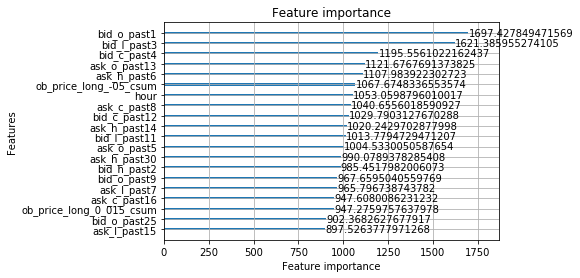

In [83]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)

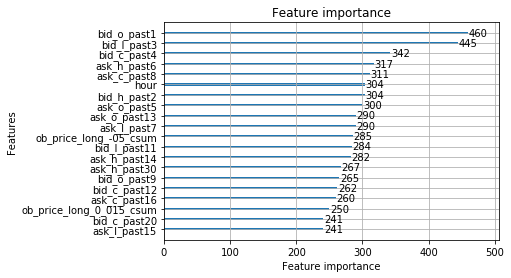

In [84]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=20)

In [85]:
def tf_to_bin(value):
    if value:
        return 1
    else:
        return 0

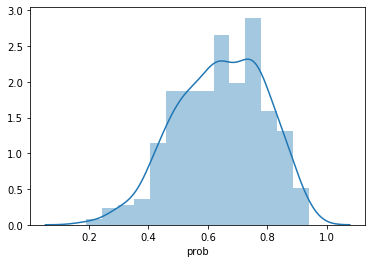

In [86]:
mds['prob'] =  lgb_model.predict(mds[model_cols])
sns.distplot(mds['prob'])

In [87]:
prob_df = pd.DataFrame()
counter = 1
for t in np.arange(0.1, 0.9, 0.0025):
    temp_test = mds.copy()
    temp_test['prob'] =  lgb_model.predict(temp_test[model_cols])
    temp_test['pred'] = temp_test['prob'].apply(lambda x: 1 if x >= t else 0)
    temp_test['tp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 1)
    temp_test['fp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 0)
    temp_test['tn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 0)
    temp_test['fn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 1)
    
    temp = pd.DataFrame()
    temp['cutoff'] = [t]
    temp['total_target'] = mds['long_target'].value_counts()[1]
    temp['tp_cnt'] =  temp_test['tp'].sum()
    temp['fp_cnt'] =  temp_test['fp'].sum()
    temp['tp_pct'] = (temp_test['tp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['fp_pct'] = (temp_test['fp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['tp_pct_total'] = (temp_test['tp'].sum() / temp_test[['tp', 'fn']].sum().sum())*100
    if counter == 1:
        prob_df = temp
        counter +=1
    else:
        prob_df = prob_df.append(temp)
        
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pl'] = (prob_df['tp_cnt'] * profit) - (prob_df['fp_cnt'] * loss)
positive = prob_df[prob_df['pl'] > 0].copy()
try:
    target_cutoff = positive[positive['pl'] == positive['pl'].max()]['cutoff'].values
    target_cutoff = target_cutoff[len(target_cutoff)-1]
except IndexError:
    print('error')
    target_cutoff= 0.5
# positive = prob_df[prob_df['pct_diff'] > 1].copy()
# target_cutoff_min = positive['cutoff'].min()
# target_cutoff_max = positive['cutoff'].max()
# positive.head()

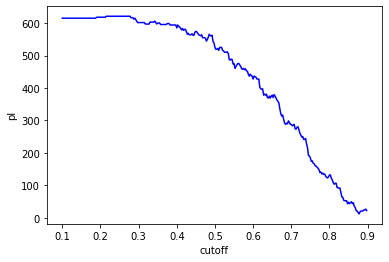

In [88]:
sns.lineplot(x='cutoff', y='pl', data=prob_df,  color='b')

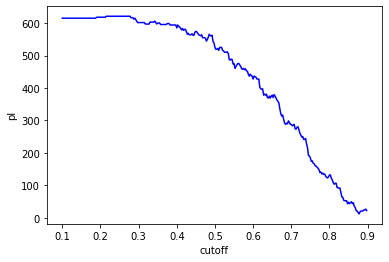

In [89]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')

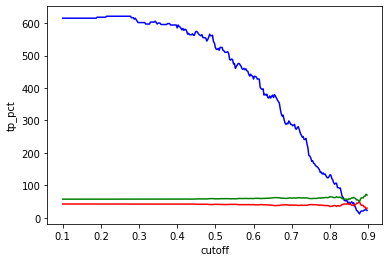

In [90]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df[prob_df['pl'] > 0],  color='r')
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df[prob_df['pl'] > 0],  color='g')

0.2775000000000002
(468, 765)
End PL - $621.0


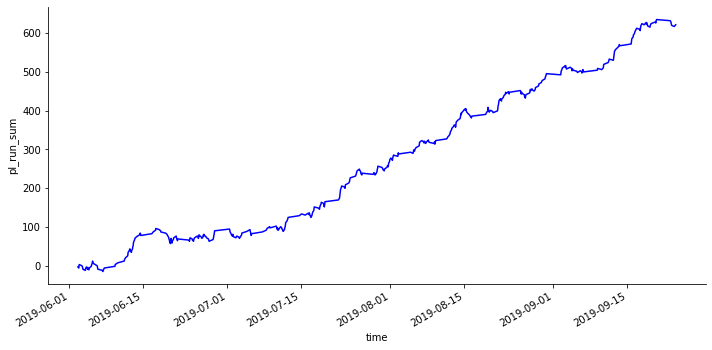

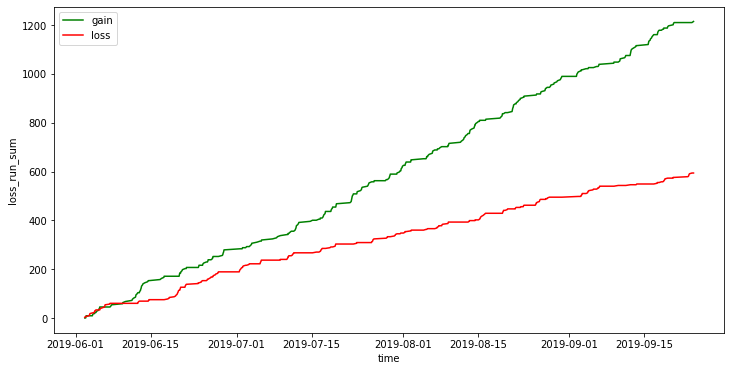

In [91]:
print(target_cutoff)
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

pl_df = pd.concat([tp, fp], axis=0)
pl_df['time'] = pd.to_datetime(pl_df['time'])
pl_df = pl_df.sort_values(by='time')
pl_df['pl_run_sum'] = pl_df['pl'].cumsum()
pl_df['gain_run_sum'] = pl_df['gain'].cumsum()
pl_df['loss_run_sum'] = pl_df['loss'].cumsum()
print(pl_df.shape)
print('End PL - ' + '$'+ str(pl_df['pl_run_sum'].tail(1).values[0]))

g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=5, aspect=2)
g.fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='time', y='gain_run_sum', data=pl_df, color='g')
sns.lineplot(x='time', y='loss_run_sum', data=pl_df, color='r')
plt.legend(['gain', 'loss'])
plt.show()

In [92]:
tp_cnt = 0
fp_cnt = 0

pl_df = pl_df.reset_index(drop=True)
pl_df['index'] = pl_df.index
pl_df['tp_up1'] = pl_df['tp'] .shift(1)
pl_df['fp_up1'] = pl_df['fp'] .shift(1)
pl_df['win_streak'] = 0
pl_df['losing_streak'] = 0
pl_df['tp_runsum'] = pl_df['tp'].cumsum()


for idx, row in pl_df.iterrows():
    if row['tp'] == 1 and row['tp_up1'] != 1.0:
        pl_df.loc[idx, 'win_streak'] = row['win_streak'] +1
        
    elif row['tp'] == 1  and  row['tp_up1'] == 1.0:
        pl_df.loc[idx, 'win_streak'] = pl_df.loc[idx-1, 'win_streak'] +1

    else:
        pl_df.loc[idx, 'win_streak'] = 0
        
    if row['fp'] == 1 and row['fp_up1'] != 1.0:
        pl_df.loc[idx, 'losing_streak'] = row['win_streak'] +1
        
    elif row['fp'] == 1  and  row['fp_up1'] == 1.0:
        pl_df.loc[idx, 'losing_streak'] = pl_df.loc[idx-1, 'losing_streak'] +1

    else:
        pl_df.loc[idx, 'losing_streak'] = 0

win_streak_start = 1
loss_streak_stop = 1
trade_cols = ['time', 'tp', 'fp', 'win_streak', 'losing_streak', 'pl', 'live_pl', 'pl_run_sum', 'gain_run_sum', 'loss_run_sum']
trade_df = pd.DataFrame(columns=trade_cols)
idx_counter = 0
while idx_counter <= pl_df.index.max():
    safe = True
    failed = False
    while not failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['losing_streak'].values[0] <= loss_streak_stop:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                tp_cnt+=1
            else:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                failed = True
                fp_cnt+=1
        else:
            failed = True
#             fp_cnt+=1

    while failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['win_streak'].values[0] <= win_streak_start:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
#                 fp_cnt+=1
            else:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1 
                failed = False
#                 tp_cnt+1
        else:
            failed = False
#             tp_cnt+=1
            
for c in list(trade_df):
    if c != 'time':
        trade_df[c] = pd.to_numeric(trade_df[c])

trade_df['live_pl_run_sum'] = trade_df['live_pl'].cumsum()
trade_df['time'] = pd.to_datetime(trade_df['time'])

# g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=trade_df, height=5, aspect=2)
# g.fig.autofmt_xdate()

print('orig total - $'  + str(trade_df['pl_run_sum'].tail(1).values[0]))
print('new total  - $' + str(trade_df['live_pl_run_sum'].tail(1).values[0]))

print(tp_cnt, fp_cnt)

orig total - $621.0
new total  - $804.0
240 38


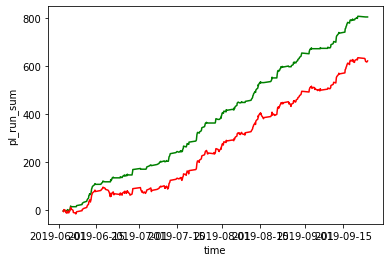

In [93]:
sns.lineplot(x='time', y='live_pl_run_sum', data=trade_df, color='g')
sns.lineplot(x='time', y='pl_run_sum', data=trade_df, color='r')

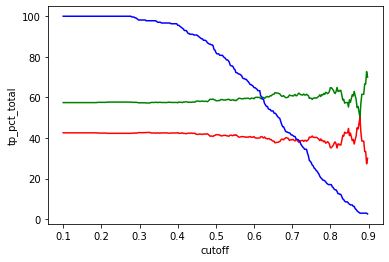

In [94]:
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=prob_df, color='b')

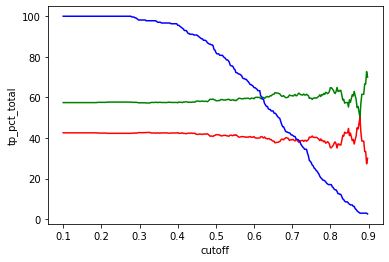

In [95]:
sns.lineplot(x='cutoff', y='tp_pct', data=positive, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=positive, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=positive, color='b')

In [96]:
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

In [97]:
#Precision
print(mds[['tp']].sum() / mds[['tp', 'fp']].sum().sum())
print()
print(mds[['tp']].sum() / mds[['tp', 'fn']].sum().sum())

tp    0.576923
dtype: float64

tp    1.0
dtype: float64


In [98]:
mds.groupby(['tp', 'fp', 'tn', 'fn']).size()

tp  fp  tn  fn
0   0   1   0       2
    1   0   0     198
1   0   0   0     270
dtype: int64

In [99]:
t = mds[mds['long_target'] == 1]
t['prob'].describe()

count    270.000000
mean       0.650687
std        0.145435
min        0.279787
25%        0.545733
50%        0.664785
75%        0.758289
max        0.928800
Name: prob, dtype: float64

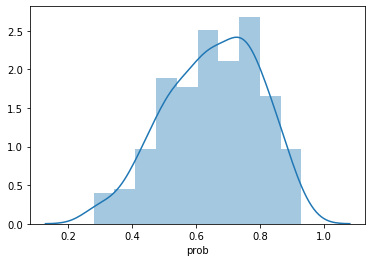

In [100]:
sns.distplot(t['prob'])

In [101]:
t['index'].min()

14449

In [102]:
t['index'].max()

16408

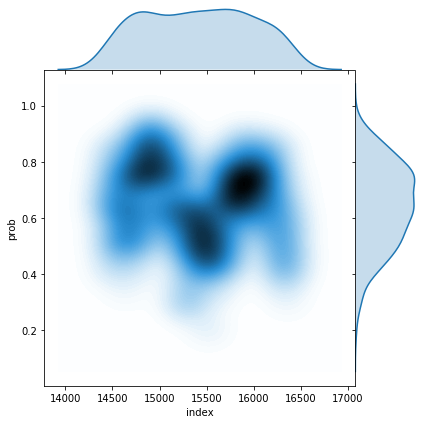

In [103]:
sns.jointplot(x='index', y='prob', data=mds, kind='kde', n_levels=100, space=0, zorder=0)

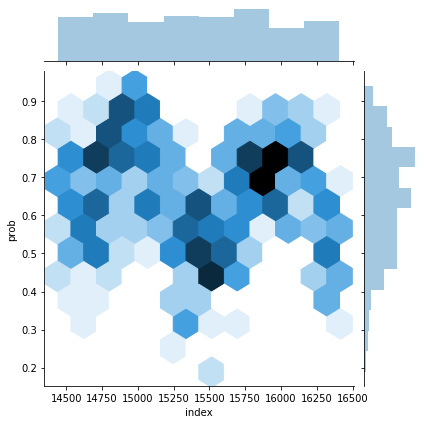

In [104]:
g = sns.jointplot(x='index', y='prob', data=mds, kind='hex')
g.savefig("probs_hex.png")

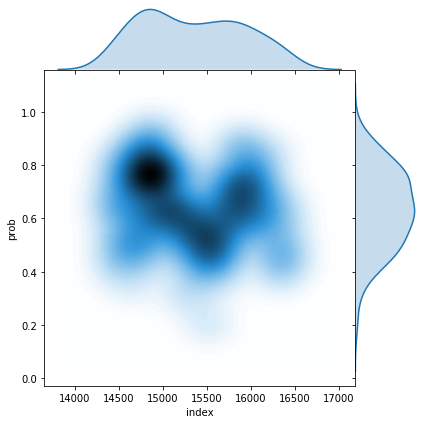

In [105]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] != 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_fp_kde.png")

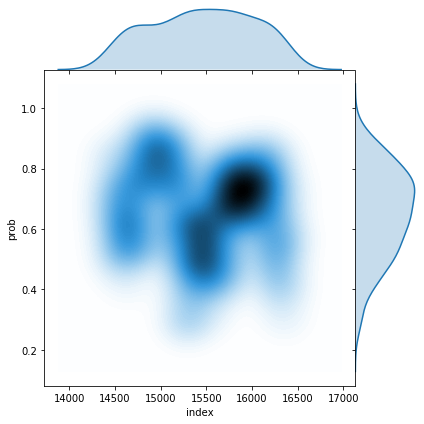

In [106]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] == 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_tp_kde.png")

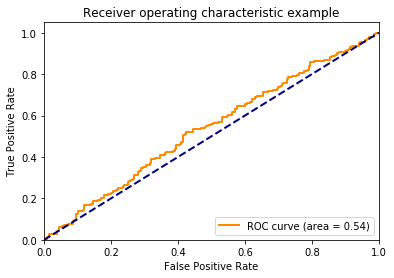

In [107]:
fpr, tpr, _ = roc_curve(mds['long_target'].values, mds['prob'].values )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [108]:
features = list(X_train)
X = X_train.apply(pd.to_numeric).values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)

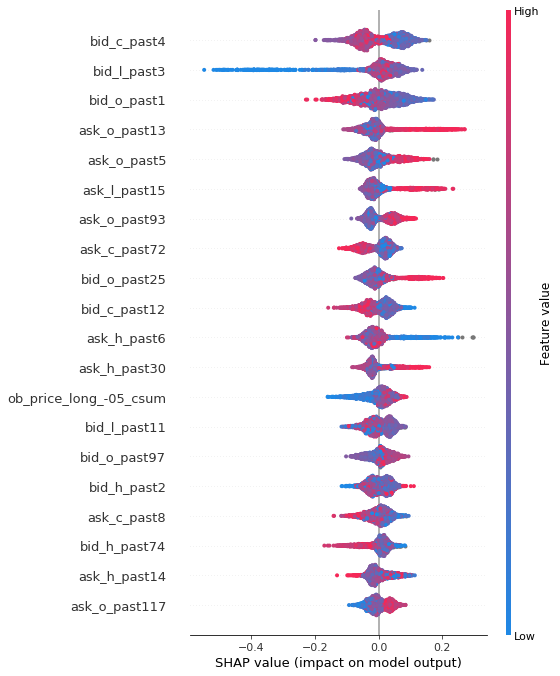

In [109]:
shap.summary_plot(shap_values, X_train, features)

In [110]:
def get_top_feats(shap_values, num_feats):
    feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
    feature_order = list(feature_order[-min(num_feats,len(feature_order)):])
    feature_order = feature_order[::-1]
    return list(X_train.iloc[:,feature_order])

top_feats = get_top_feats(shap_values, 20)
top_feats

['bid_c_past4',
 'bid_l_past3',
 'bid_o_past1',
 'ask_o_past13',
 'ask_o_past5',
 'ask_l_past15',
 'ask_o_past93',
 'ask_c_past72',
 'bid_o_past25',
 'bid_c_past12',
 'ask_h_past6',
 'ask_h_past30',
 'ob_price_long_-05_csum',
 'bid_l_past11',
 'bid_o_past97',
 'bid_h_past2',
 'ask_c_past8',
 'bid_h_past74',
 'ask_h_past14',
 'ask_o_past117']

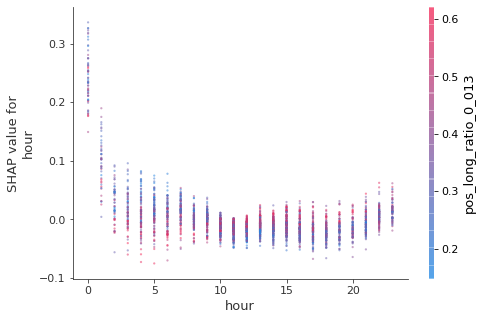

In [111]:
shap.dependence_plot('hour', shap_values, X, X_train.columns, interaction_index='auto',
                             alpha=0.5, dot_size=5, show=False)

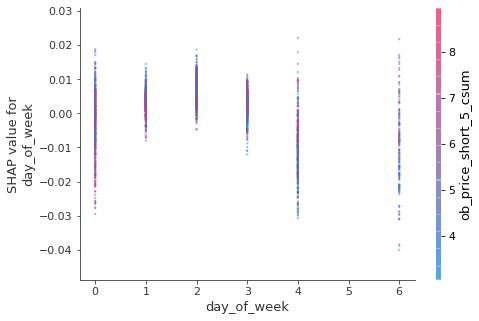

In [112]:
shap.dependence_plot('day_of_week', shap_values, X, X_train.columns, interaction_index='auto',
                             alpha=0.5, dot_size=5, show=False)


In [113]:
mds.groupby(['day_of_week', 'tp', 'fp', 'tn', 'fn']).size() / len(mds)

day_of_week  tp  fp  tn  fn
0            0   1   0   0     0.070213
             1   0   0   0     0.112766
1            0   1   0   0     0.082979
             1   0   0   0     0.091489
2            0   1   0   0     0.080851
             1   0   0   0     0.127660
3            0   1   0   0     0.087234
             1   0   0   0     0.104255
4            0   0   1   0     0.002128
                 1   0   0     0.082979
             1   0   0   0     0.100000
6            0   0   1   0     0.002128
                 1   0   0     0.017021
             1   0   0   0     0.038298
dtype: float64

In [114]:
# for name in top_feats:
#     print(name)
#     shap.dependence_plot(name, shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)
#     plt.show()

In [115]:
# result_df = result_df.sort_values(by='time')
# result_df = result_df.reset_index(drop=True)
# result_df['id'] = result_df.index
# result_df.to_csv('long_preds_v3.csv', index=False, header=True)

In [116]:
lgb_model.save_model('oanda_EURUSD_long_v7_USDCAD.txt', num_iteration=-1)
layout_df = pd.DataFrame(list(X_train), columns=['features'])
layout_df.to_csv('oanda_EURUSD_long_v7_layout_USDCAD.csv', index=False, header=True)

info_df = pd.DataFrame()
info_df['long_target_diff'] = [target_diff]
info_df['long_stop_loss'] = stop_loss
info_df['l_target_cutoff'] = target_cutoff
info_df['l_profit'] = profit
info_df['l_loss'] = loss

info_df.to_csv('oanda_EURUSD_long_v7_info_USDCAD.csv', index=False, header=True)

In [117]:
info_df

,long_target_diff,long_stop_loss,l_target_cutoff,l_profit,l_loss
0,0.003,0.002,0.2775,4.5,3


In [118]:
mds[['time', 'target_tp', 'target_sl', 'bid_c', 'bid_l', 'ask_c', 'ask_h', 'g', 'l', 'g_time', 'l_time', 'long_target', 'short_target']].head(10)

,time,target_tp,target_sl,bid_c,bid_l,ask_c,ask_h,g,l,g_time,l_time,long_target,short_target
4327,2019-06-02 17:00:00,1.35417,1.34817,1.35117,1.35115,1.35217,1.35238,0.0,14461.0,NaN,2019-06-03 10:00:00,0,1
4328,2019-06-02 21:00:00,1.35312,1.34794,1.35094,1.35094,1.35112,1.35246,0.0,14462.0,NaN,2019-06-03 11:00:00,0,1
4329,2019-06-02 22:00:00,1.35222,1.34705,1.35005,1.34984,1.35022,1.35154,14456.0,0.0,2019-06-03 05:00:00,NaN,1,0
4330,2019-06-02 23:00:00,1.35144,1.34627,1.34927,1.34920,1.34944,1.35030,14455.0,0.0,2019-06-03 04:00:00,NaN,1,0
4331,2019-06-03 11:00:00,1.34955,1.34439,1.34739,1.34569,1.34755,1.35030,0.0,14466.0,NaN,2019-06-03 15:00:00,0,1
4332,2019-06-03 14:00:00,1.34723,1.34206,1.34506,1.34470,1.34523,1.34719,0.0,14479.0,NaN,2019-06-04 04:00:00,0,1
4333,2019-06-03 15:00:00,1.34568,1.34052,1.34352,1.34341,1.34368,1.34547,0.0,14488.0,NaN,2019-06-04 13:00:00,0,1
4334,2019-06-03 16:00:00,1.34669,1.34153,1.34453,1.34340,1.34469,1.34501,0.0,14485.0,NaN,2019-06-04 10:00:00,0,1
4335,2019-06-04 03:00:00,1.34527,1.34011,1.34311,1.34272,1.34327,1.34407,0.0,14489.0,NaN,2019-06-04 14:00:00,0,1
4336,2019-06-04 04:00:00,1.34503,1.33987,1.34287,1.34198,1.34303,1.34340,14481.0,0.0,2019-06-04 06:00:00,NaN,1,0
